# NMA CN Project

## Imports

In [1]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
np.random.seed(42)

## Setup AllenSDK

In [3]:
DATA_STORAGE_DIRECTORY = Path("./allensdk_storage")

In [4]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=DATA_STORAGE_DIRECTORY)

In [5]:
sessions_df = cache.get_behavior_session_table()
experiments_df = cache.get_ophys_experiment_table()

## Specify Experiment

### Cre Line

<img style="width: 50%" src="images/cre_lines.png">

In [6]:
# We are looking at excitatory cells
CRE_LINE = "Slc17a7-IRES2-Cre"

### Project Code

<img style="width: 50%" src="images/variants_table.png">

In [7]:
# We are looking at single-plane imaging
# "VisualBehavior" or "VisualBehaviorTask1B"
PROJECT_CODE = "VisualBehavior"

### Experiment

<img style="width: 50%" src="images/data_structure.png">

#### `OPHYS_CONTAINER_ID`

In [8]:
experiments_df.query("project_code == @PROJECT_CODE").query("cre_line == @CRE_LINE")["ophys_container_id"].unique()

array([876693090, 869781307, 863992815, 930022332, 902748564, 930024022,
       848390542, 845588020, 782536745, 968451510, 939523510, 902748650,
       890047007, 803516615, 803517529, 812858755, 876693136, 846213087,
       843049827, 829561794, 876461613, 814796612, 803589437, 846215539])

In [9]:
OPHYS_CONTAINER_ID = 876693090

#### `MOUSE_ID`

In [10]:
experiments_df.query("project_code == @PROJECT_CODE").query("cre_line == @CRE_LINE").query("ophys_container_id == @OPHYS_CONTAINER_ID")["mouse_id"].unique()

array([449441])

In [11]:
MOUSE_ID = 449441

#### `ACTIVE_SESSION`, `PASSIVE_SESSION`

In [12]:
# All available sessions
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("cre_line == @CRE_LINE") \
              .query("ophys_container_id == @OPHYS_CONTAINER_ID") \
              .query("mouse_id == @MOUSE_ID") \
              ["session_type"].unique()

array(['OPHYS_2_images_A_passive', 'OPHYS_1_images_A', 'OPHYS_4_images_B',
       'OPHYS_6_images_B', 'OPHYS_5_images_B_passive'], dtype=object)

In [13]:
# We are looking at one active and one passive session, but not all might be available for each mouse
# These are the active sessions:
# - OPHYS_1_images_A/B
# - OPHYS_3_images_A/B
# - OPHYS_4_images_A/B
# - OPHYS_6_images_A/B
ACTIVE_SESSION = "OPHYS_1_images_A"
# These are the passive sessions:
# - OPHYS_2_images_A/B_passive
# - OPHYS_5_images_A/B_passive
PASSIVE_SESSION = "OPHYS_2_images_A_passive"

#### `ACTIVE_EXPERIMENT_ID`, `PASSIVE_EXPERIMENT_ID`

In [14]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("cre_line == @CRE_LINE") \
              .query("ophys_container_id == @OPHYS_CONTAINER_ID") \
              .query("mouse_id == @MOUSE_ID") \
              .query("session_type == @ACTIVE_SESSION").index

Int64Index([879332693], dtype='int64', name='ophys_experiment_id')

In [15]:
ACTIVE_EXPERIMENT_ID = 879332693

In [16]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("cre_line == @CRE_LINE") \
              .query("ophys_container_id == @OPHYS_CONTAINER_ID") \
              .query("session_type == @PASSIVE_SESSION").index.values[0]

877696762

In [17]:
PASSIVE_EXPERIMENT_ID = 877696762

## Cell Selection

In [18]:
active_experiment = cache.get_behavior_ophys_experiment(ACTIVE_EXPERIMENT_ID)

In [19]:
def get_cell_specimen_ids(experiment):
    """
    Get all the cell specimen ids recorded in the experiment.
    """
    return experiment.dff_traces.index

In [20]:
def get_indices_in_interval(experiment, start, end):
    indices = np.argwhere((experiment.ophys_timestamps >= start) & (experiment.ophys_timestamps <= end))[:, 0]
    return indices

In [21]:
def get_timestamps_in_interval(experiment, cell_speciment_id, start, end):
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.ophys_timestamps[indices]

In [22]:
def get_dff_in_interval(experiment, cell_specimen_id, start, end):
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.dff_traces.loc[cell_specimen_id]["dff"][indices[0]:indices[-1]+1]

### For single stimulus

In [23]:
stimulus_start_time = float(active_experiment.stimulus_presentations.loc[0]["start_time"])

100%|██████████| 415/415 [00:00<00:00, 567.54it/s]


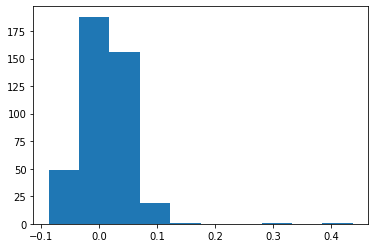

In [24]:
diffs = []
for cell_specimen_id in tqdm(get_cell_specimen_ids(active_experiment)):
    trace_before_stimulus = get_dff_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time)
    trace_after_stimulus = get_dff_in_interval(active_experiment, cell_specimen_id, stimulus_start_time, stimulus_start_time+0.25)

    diffs.append(np.mean(trace_after_stimulus) - np.mean(trace_before_stimulus))
plt.hist(diffs);

In [25]:
cell_specimen_ids = get_cell_specimen_ids(active_experiment)
cell_specimen_ids[np.argmax(diffs)]

1086604838

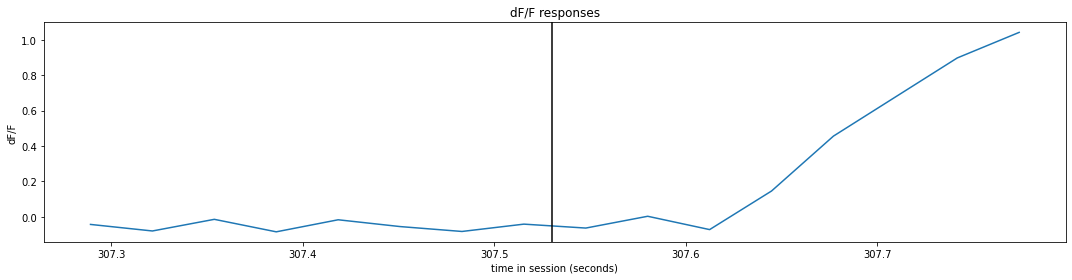

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))

for cell_specimen_id in [1086604838]:
    ax.plot(
        get_timestamps_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
        get_dff_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
    )

ax.axvline(x=stimulus_start_time, color="k", linestyle="-")
ax.set_title('dF/F responses')
ax.set_ylabel('dF/F')
ax.set_xlabel('time in session (seconds)')
fig.tight_layout()
fig.show()

### For all stimulus

In [27]:
stimulus_start_times = active_experiment.stimulus_presentations["start_time"]

In [28]:
active_experiment.dff_traces.head(5)

,cell_roi_id,dff
cell_specimen_id,,
1086601848,1080867796,"[0.28201794368039823, 0.1903022438869266, 0.21..."
1086602069,1080867804,"[0.13884965897445056, 0.3963619942985226, 0.24..."
1086635982,1080867837,"[0.5498754867600153, 0.26557468920820837, 0.43..."
1086578646,1080867844,"[0.20886659311964556, 0.08442318243036104, 0.2..."
1086598188,1080867847,"[0.28967144653172083, 0.49236151316004095, 0.4..."


In [29]:
dff_matrix = np.array(active_experiment.dff_traces["dff"].tolist())

In [30]:
diff_traces_per_stimulus = []
for stimulus_start_time in tqdm(stimulus_start_times):
    diffs = []
    before_indices = get_indices_in_interval(active_experiment, stimulus_start_time-0.25, stimulus_start_time)
    after_indices = get_indices_in_interval(active_experiment, stimulus_start_time, stimulus_start_time+0.25)
    before_mean_traces = np.mean(dff_matrix[:, before_indices], axis=1)
    after_mean_traces = np.mean(dff_matrix[:, after_indices], axis=1)
    diff_traces = after_mean_traces - before_mean_traces
    diff_traces_per_stimulus.append(diff_traces)

100%|██████████| 4807/4807 [00:02<00:00, 2144.42it/s]


In [31]:
diff_matrix = np.stack(diff_traces_per_stimulus, axis=1)

In [32]:
mean_diff_per_cell = np.mean(diff_matrix, axis=1)

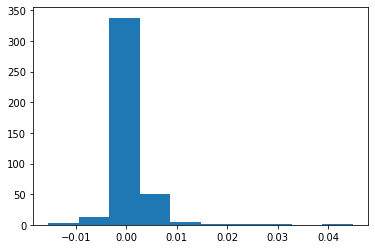

In [33]:
plt.hist(mean_diff_per_cell);

In [34]:
cell_specimen_ids = get_cell_specimen_ids(active_experiment)
cell_specimen_ids[np.argmax(mean_diff_per_cell)]

1086578313

In [35]:
np.max(mean_diff_per_cell)

0.04483521741441901

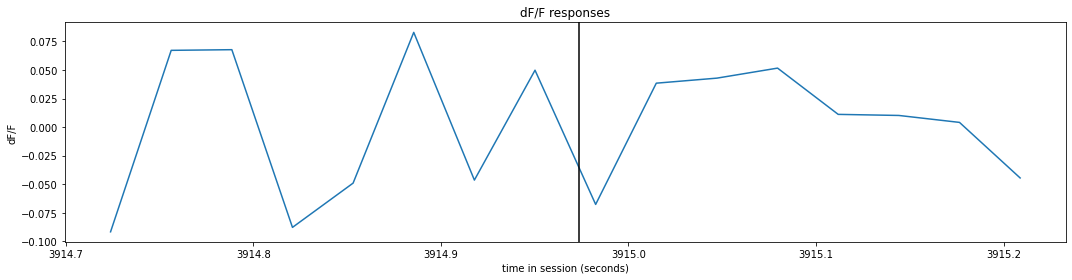

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))

for cell_specimen_id in [1086578313]:
    ax.plot(
        get_timestamps_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
        get_dff_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
    )

ax.axvline(x=stimulus_start_time, color="k", linestyle="-")
ax.set_title('dF/F responses')
ax.set_ylabel('dF/F')
ax.set_xlabel('time in session (seconds)')
fig.tight_layout()
fig.show()

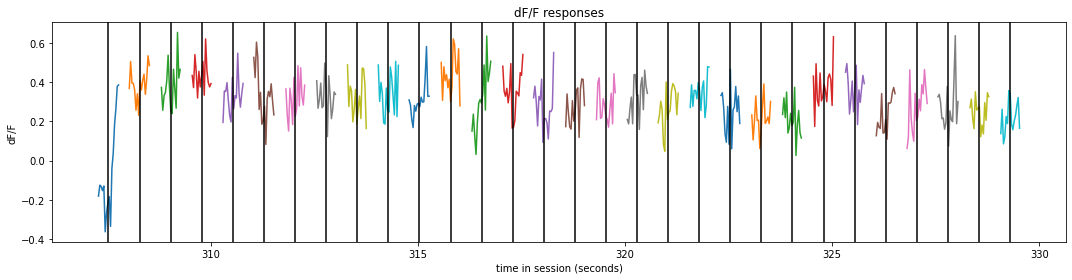

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))

for stimulus_start_time in stimulus_start_times[:30]:
    for cell_specimen_id in [1086578313]:
        ax.plot(
            get_timestamps_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
            get_dff_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
        )
    ax.axvline(x=stimulus_start_time, color="k", linestyle="-")

ax.set_title('dF/F responses')
ax.set_ylabel('dF/F')
ax.set_xlabel('time in session (seconds)')
fig.tight_layout()
fig.show()